# Dataset

Sobre el Fitness Club Dataset (1501) GoalZone es una cadena de gimnasios en Canadá.

ofrece una variedad de clases de fitness en dos capacidades: 25 y 15.
Algunas clases siempre están completas.
Las clases totalmente reservadas suelen tener un bajo índice de asistencia.
Necesidad:

quiere aumentar la cantidad de espacios disponibles para clases.

Requerimiento:

Quieren hacer esto prediciendo si el miembro asistirá a la clase o no.

Resultado:

Si pueden predecir que un miembro no asistirá a la clase, pueden poner a disposición otro espacio.

## Columnas
tenemos 8 columnas:

*   `id_reserva `: (Number). El identificador único de la reserva.
*   `meses_como_miembro `: (Number).  El número de meses como miembro de este gimnasio, mínimo 1 mes.
*   `peso `: Nominal. Peso del socio en kg, redondeado a 2 decimales.
*   `días antes `: (Number). El número de días antes de la clase que el miembro se registró.
*   `día de la semana `: (String). El día de la semana de la clase.(Mon,Tue, Wed, Thu, Fri, Sat, Sun)
*   `tiempo `: (String). La hora del día de la clase. Ya sea por la mañana o por la tarde. (AM, PM)
*   `categoría `: La categoría de la clase de fitness.()
*   `asistió `: (Binario). Si el miembro asistió a la clase (1) o no (0).

# Librerías

In [2]:
# Librerías
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


# For facets
from IPython.display import display, HTML
import base64
!pip install facets-overview==1.1.1

from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=c67c01d8e8d550787e1b83e71b50b93892b665754deb092bcdab246a83a7784c
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


# Cargar el Dataset

In [3]:
url = "https://raw.githubusercontent.com/Darek0211/datasets/main/fitness_class_2212.csv"
dataset= pd.read_csv(url)
dataset

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.51,10,Fri,AM,HIIT,0
1496,1497,29,89.55,2,Mon,AM,Strength,0
1497,1498,9,87.38,4,Tue,AM,HIIT,0
1498,1499,34,68.64,14,Sun,AM,Aqua,0


# Análisis exploratorio de datos

In [4]:
fsg=FeatureStatisticsGenerator()

dataframes=[{'table': dataset, 'name': 'trainData'}]
GymProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(GymProto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          var data = "{protostr}";
          document.querySelector("#elem").protoInput = data;
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

#Analisis con Facets para el dataset el Fitness Club





1. no tenemos datos de caracteristicas perdidas.
2. hay un tendencia mayor a la mitad de las reseves de las clases donde las personas no aisisten.
3. dentro de las categorias existen sesgo como:
* Aqua:
Sesgo de género: Los estereotipos de género pueden influir en las expectativas sobre quién debería participar en clases de entrenamiento acuático puesto que se puede asumir que esta cartegiria es para las mujeres por eso vemos poca participacion de las personas.
* Strength (Fuerza): Puede haber un sesgo que sugiera que el entrenamiento de fuerza es solo para personas jóvenes, lo que podría disuadir a personas mayores de participar,.
4. peso puede el modelo tener un sesgo ya que Si estos rangos de peso se utilizan para tomar decisiones importantes, como la admisión a clases de fitness, la asignación de entrenadores personales o la evaluación del progreso de un cliente, podría haber un sesgo de discriminación si no se trata a todas las personas de manera justa y equitativa, Dependiendo de cómo se utilicen estos rangos de peso, podría haber un sesgo de estigmatización hacia las personas que se encuentran en ciertas categorías. Por ejemplo,si se asignan valores más bajos a los rangos de peso más altos, esto podría llevar a la estigmatización de las personas con sobrepeso u obesidad.

In [5]:
train_dive = dataset.to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="1200"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=train_dive)
display(HTML(html))

# Modelo de aprendizaje automático

Como se mostró en el apartado anterior, el dataset tiene dos tipos de información, la primera son los datos numericos que abarcan los campos:

- months_as_member.
- weight
- days_before
- attended
- booking_id

El segundo tipo de información son categóricos estos son conjunto de objetos que representan
- Time
- day_of_week
- category

Esta información debe ser ajustada y escalada para que el modelo pueda interpretar mejor su influencia como entrada. Para este ajuste primero se realiza la eliminicación de todas aquellas filas que tengan algún campo como nulo y se asignan las variables y_DATA como nuestra salida esperada, y x_Data como nuestro conjunto de entrenamiento.

Para esta última se decide no utilizar el cambo booking_id pues este dato es único por registro por lo que su influenia solo restaría calidad al modelo.  

**Limpieza de datos**

In [6]:
dataset=dataset.dropna(how="any", axis=0)
dataset

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.51,10,Fri,AM,HIIT,0
1496,1497,29,89.55,2,Mon,AM,Strength,0
1497,1498,9,87.38,4,Tue,AM,HIIT,0
1498,1499,34,68.64,14,Sun,AM,Aqua,0


**Modelo**

In [7]:
# Salida esperada del modelo
y_Data = dataset['attended']

# conjunto de entrada
x_Data = np.column_stack((dataset["months_as_member"],
                          dataset["weight"],
                          dataset["days_before"],
                          dataset["day_of_week"],
                          dataset["time"],
                          dataset["category"],))

Se crea un método específico que cambia la naturaleza de los campos de tipo categoría a número.

Define un diccionario por cada categoría y deacuerdo al índice de cada uno asigna si equivanente en número.

- En el campo Time "AM": 0,"PM": 1
- En el campo day_of_week  "Mon": 0,"Tue": 1,"Wed": 2,"Thu": 3,"Fri": 4,"Sat": 5,"Sun": 6
- en el campo category   "Aqua": 0, "Yoga":1, "Strength":2, "Cycling":3, "HIIT":4

Donde su salida es el array con los cambios mencionados.  

In [8]:
# Metodo de transformada de entrada x
# Le entra la data y el número de columna donde esta la categoría
# es decir contandop de 1 a n
# donde n es la columna donde esta la categoría
# n-1 posición de categoría
# n-2 posición de timepo
# n-3 posición día de la semana
def funTranforInfo (inuData, space):
    # Definir el diccionario de mapeo para reeemplazar los objetos por su equivalencia en número
    # day_of_week
    mapeo_day_of_week = {"Mon": 0,"Tue": 1,"Wed": 2,"Thu": 3,"Fri": 4,"Sat": 5,"Sun": 6}
    # Time
    mapeo_Time = {"AM": 0,"PM": 1}
    # category
    mapeo_category  = {"Aqua": 0, "Yoga":1, "Strength":2, "Cycling":3, "HIIT":4}

    # day_of_week
    columna_a_transformar_1 = inuData[:, space-3]

    columna_transformada_1 = np.vectorize(lambda x: mapeo_day_of_week.get(x, x))(columna_a_transformar_1)

    inuData[:, space-3] = columna_transformada_1

    # time
    columna_a_transformar_2 = inuData[:, space-2]

    columna_transformada_2 = np.vectorize(lambda x: mapeo_Time.get(x, x))(columna_a_transformar_2)

    inuData[:, space-2] = columna_transformada_2

    # Category
    columna_a_transformar_3 = inuData[:, space-1]

    columna_transformada_3 = np.vectorize(lambda x: mapeo_category.get(x, x))(columna_a_transformar_3)

    inuData[:, space-1] = columna_transformada_1

    return inuData

Validación del método de adaptación de campos no numericos, y se verifica la salida.

In [9]:
# se ejecuta el método de adaptación del cambio
x_Data = funTranforInfo(x_Data,6)

x_Data, y_Data

(array([[17, 79.56, 8, 2, 1, 2],
        [10, 79.01, 2, 0, 0, 0],
        [16, 74.53, 14, 6, 0, 6],
        ...,
        [9, 87.38, 4, 1, 0, 1],
        [34, 68.64, 14, 6, 0, 6],
        [20, 94.39, 8, 3, 0, 3]], dtype=object),
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1495    0
 1496    0
 1497    0
 1498    0
 1499    1
 Name: attended, Length: 1467, dtype: int64)

# Normalización

In [10]:
scaler=MinMaxScaler()
x_scaled=scaler.fit_transform(x_Data)
x_Data

array([[17, 79.56, 8, 2, 1, 2],
       [10, 79.01, 2, 0, 0, 0],
       [16, 74.53, 14, 6, 0, 6],
       ...,
       [9, 87.38, 4, 1, 0, 1],
       [34, 68.64, 14, 6, 0, 6],
       [20, 94.39, 8, 3, 0, 3]], dtype=object)

División del Dataset

In [11]:
x_train, x_test, y_train, y_test=train_test_split(x_scaled, y_Data, test_size=0.3, random_state=42)
x_train.shape, x_test.shape

((1026, 6), (441, 6))

# Red neuronal

Se plantea un módelo de aprendizaje automático de tres capas ocultas, estas tienen como función de activación tanh y al modelo se le busca optener las siguientes métricas:

  - TruePositives
  - FalsePositives
  - TrueNegatives
  - FalseNegatives
  - BinaryAccuracy
  - Precision
  - metrics.Recall
  - AUC

In [12]:
HIDDEN_UNITS_LAYER_01=6
HIDDEN_UNITS_LAYER_02=12
HIDDEN_UNITS_LAYER_03=6
LEARNING_RATE=0.4

RANDOM_SEED=512
tf.random.set_seed(RANDOM_SEED)

METRICS=[
    keras.metrics.TruePositives(name='TP'),
    keras.metrics.FalsePositives(name="FP"),
    keras.metrics.TrueNegatives(name="TN"),
    keras.metrics.FalseNegatives(name="FN"),

    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

modelo=tf.keras.Sequential([
    keras.layers.Dense(
        HIDDEN_UNITS_LAYER_01, input_shape=(6,), activation='tanh'),
    keras.layers.Dense(HIDDEN_UNITS_LAYER_02, activation='tanh'),
  keras.layers.Dense(HIDDEN_UNITS_LAYER_03, activation='tanh'),
  keras.layers.Dense(1, activation='sigmoid')
])

modelo.build()
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 211 (844.00 Byte)
Trainable params: 211 (844.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


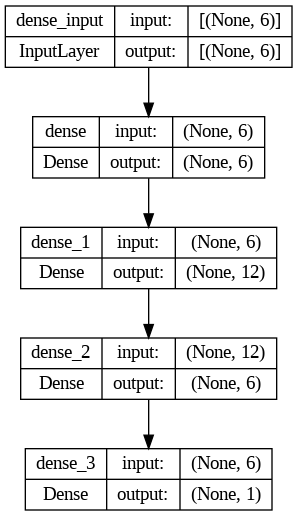

In [13]:
keras.utils.plot_model(modelo, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Compilación del modelo y entrenamiento

In [14]:
modelo.compile('rmsprop','BinaryCrossentropy',metrics=METRICS)

In [15]:
historia = modelo.fit(x_train, y_train, epochs=500, verbose=0)

# Resultados del modelo

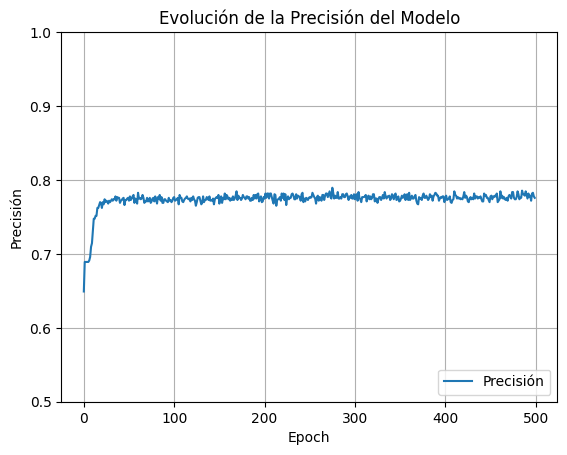

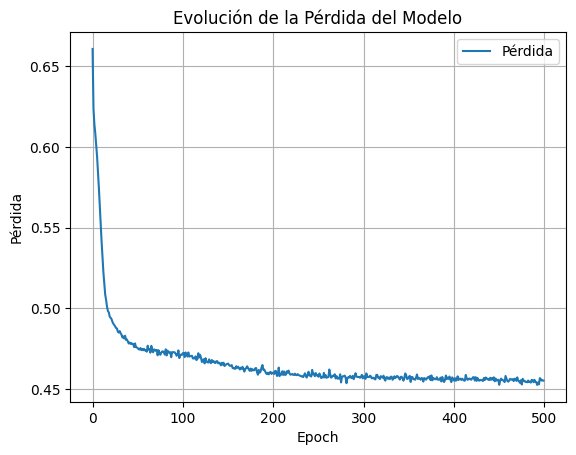

In [16]:
plt.plot(historia.history['accuracy'], label='Precisión')
plt.title('Evolución de la Precisión del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Precisión')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.grid('on')
plt.show()

# Plot training & validation loss values
plt.plot(historia.history['loss'], label='Pérdida')
plt.title('Evolución de la Pérdida del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.grid('on')
plt.show()

# Matriz de confusión

In [17]:
# Define Function to Visualize Binary Confusion Matrix
def plot_confusion_matrix(
    confusion_matrix, class_names, subgroup, figsize = (8,6)):
  # We're taking our calculated binary confusion matrix that's already in the
  # form of an array and turning it into a pandas DataFrame because it's a lot
  # easier to work with a pandas DataFrame when visualizing a heat map in
  # Seaborn.
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  rcParams.update({
  'font.family':'sans-serif',
  'font.sans-serif':['Liberation Sans'],
  })

  sns.set_context("notebook", font_scale=1.25)

  fig = plt.figure(figsize=figsize)

  plt.title('Confusion Matrix for Performance Across ' + subgroup)

  # Combine the instance (numercial value) with its description
  strings = np.asarray([['True Positives', 'False Negatives'],
                        ['False Positives', 'True Negatives']])
  labels = (np.asarray(
      ["{0:g}\n{1}".format(value, string) for string, value in zip(
          strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

  heatmap = sns.heatmap(df_cm, annot=labels, fmt="",
      linewidths=2.0, cmap=sns.color_palette("GnBu_d"));
  heatmap.yaxis.set_ticklabels(
      heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  heatmap.xaxis.set_ticklabels(
      heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
  plt.ylabel('References')
  plt.xlabel('Predictions')
  return fig

Matríz de confusión de modelo de prueba

,ACCURACY,PRECISION,RECALL,AUC
Test,0.7800,0.6396,0.5547,0.8000


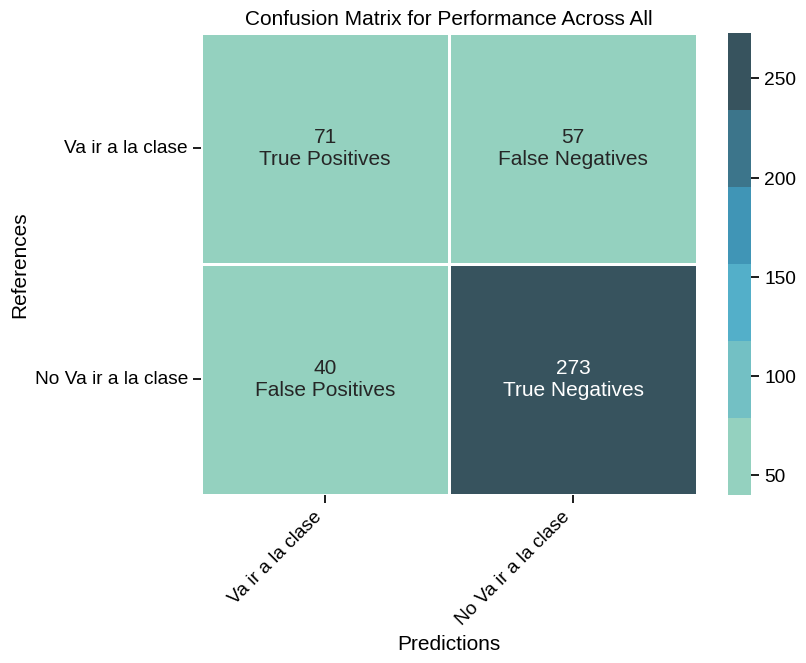

In [18]:
# Labels for annotating axes in plot.
classes = ['Va ir a la clase', 'No Va ir a la clase']

# Given define subgroup, generate predictions and obtain its corresponding
# ground truth.

features, labels = x_test,y_test
group_results = modelo.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[group_results[1], group_results[4]],
                             [group_results[2], group_results[3]]])

group_performance_metrics = {
    'ACCURACY': group_results[5],
    'PRECISION': group_results[6],
    'RECALL': group_results[7],
    'AUC': group_results[8]
}
performance_df = pd.DataFrame(group_performance_metrics, index=["Test"])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, 'All');
performance_df

Matríz de confusión del modelo entrenado.

,ACCURACY,PRECISION,RECALL,AUC
Test,0.7757,0.6578,0.5503,0.8248


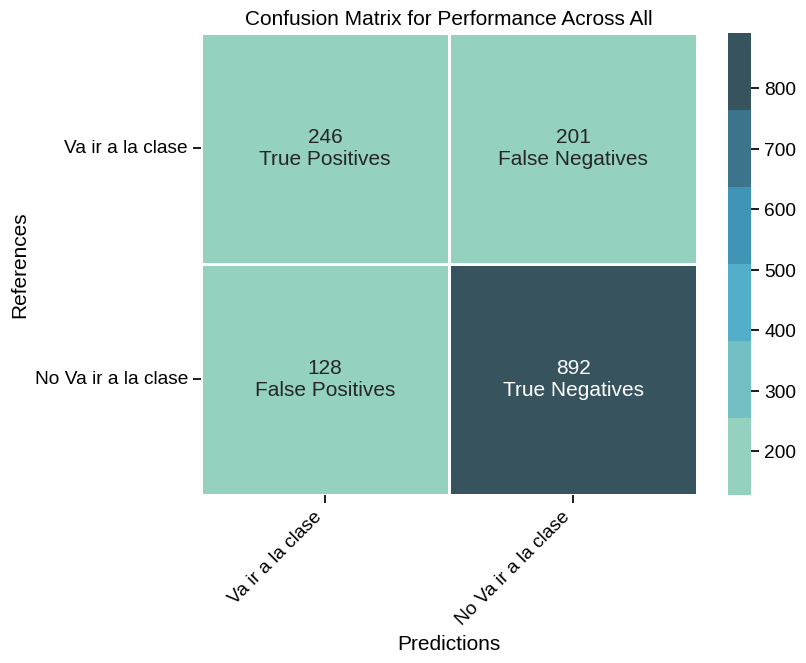

In [19]:
# Labels for annotating axes in plot.
classes = ['Va ir a la clase', 'No Va ir a la clase']

# Given define subgroup, generate predictions and obtain its corresponding
# ground truth.

features, labels = x_scaled,y_Data
group_results = modelo.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[group_results[1], group_results[4]],
                             [group_results[2], group_results[3]]])

group_performance_metrics = {
    'ACCURACY': group_results[5],
    'PRECISION': group_results[6],
    'RECALL': group_results[7],
    'AUC': group_results[8]
}
performance_df = pd.DataFrame(group_performance_metrics, index=["Test"])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, 'All');
performance_df